<a href="https://colab.research.google.com/github/parmarsuraj99/keras-transformer-flex/blob/master/VirTex/CaptFormer_Exp_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers

     |████████████████████████████████| 675kB 2.7MB/s 
     |████████████████████████████████| 1.1MB 13.7MB/s 
     |████████████████████████████████| 3.8MB 17.0MB/s 
     |████████████████████████████████| 890kB 41.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=5f4b1dd825d46e42c6bcdb3e67c2aef45ac5d329c59da0e01fdfe41a6f51cf33
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [0]:
import gc
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img

In [0]:
def scaled_dot_product_attention(query, key, value, mask):
  """Calculate the attention weights. """
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # scale matmul_qk
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # add the mask to zero out padding tokens
  if mask is not None:
    logits += (mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k)
  attention_weights = tf.nn.softmax(logits, axis=-1)

  output = tf.matmul(attention_weights, value)

  return output

In [0]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, query, key, value, mask):
    batch_size = tf.shape(query)[0]

    # linear layers
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # split heads
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # scaled dot-product attention
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # concatenation of heads
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # final linear layer
    outputs = self.dense(concat_attention)

    return outputs

In [0]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((20, 30, 512))  # (batch_size, encoder_sequence, d_model)
out = temp_mha(y, y, y, mask=None)
out.shape

TensorShape([20, 30, 512])

In [0]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])


In [0]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.self_attn = MultiHeadAttention(d_model, num_heads)
    self.mha = MultiHeadAttention(d_model, num_heads)

    self.ffn1 = tf.keras.layers.Dense(dff, activation='relu')
    self.dropout = tf.keras.layers.Dropout(rate)
    self.ffn2 = tf.keras.layers.Dense(d_model)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
  def call(self, tgt, enc_output, trainin=True,
           look_ahead_mask=None, padding_mask=None):
      
    #Changed First layernorm then attn
    tgt = self.layernorm1(tgt)
    tgt2 = self.self_attn(tgt, tgt, tgt, mask=look_ahead_mask)
    #print(tgt2.shape)
    tgt = tgt + self.dropout1(tgt2)
    
    #print(enc_output.shape)
    #LAyernorm then decoder attn
    tgt = self.layernorm2(tgt)
    tgt2 = self.mha(tgt, enc_output, enc_output, mask=look_ahead_mask)
    tgt = tgt + self.dropout2(tgt2)
    
    #Layernorm then FFN
    tgt = self.layernorm3(tgt)
    tgt2 = self.ffn2(self.dropout(self.ffn1(tgt),training))
    tgt = tgt + self.dropout3(tgt2)
    

    return tgt

In [0]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):

    attention_weights = {}

    for i in range(self.num_layers):
      x = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)
    
    # x.shape == (batch_size, target_seq_len, d_model)
    return x


In [0]:


class Virtex(layers.Layer):

  def __init__(self, num_classes, hidden_dim, nheads,
               num_encoder_layers, num_decoder_layers, vocab_size):
    super(Virtex, self).__init__()
    self.backbone = tf.keras.applications.ResNet50(
            input_shape=(3, None, None),
            include_top=False,
            weights="imagenet",
            )
    self.conv = L.Conv2D(hidden_dim, 1)
    self.transformer = Transformer(d_model = hidden_dim, num_heads=nheads,
                                   num_encoding_layers=num_encoder_layers,
                                   num_decoding_layers=num_decoder_layers)
    self.linear_class = L.Dense(num_classes+1)
    self.query_pos = tf.Variable(tf.random.uniform([1, hidden_dim]))
    self.row_embed = tf.Variable(tf.random.uniform([50, hidden_dim//2]))
    self.col_embed = tf.Variable(tf.random.uniform([50, hidden_dim//2]))
    self.embeddings = L.Embedding(vocab_size, 256)


  def call(self, inputs, text):
      x = self.backbone(inputs)
      h = self.conv(x)
      print(h.shape)
      H, W  = h.shape[-2:]
      print(H, W)
      print(self.query_pos.shape)
      cated = tf.concat([tf.tile(tf.expand_dims(self.col_embed[:W], 0), [H, 1, 1]),
                         tf.tile(tf.expand_dims(self.row_embed[:H], 1), [1, W, 1])
                         ], axis = -1)
      cated = tf.expand_dims(tf.reshape(cated, [H*W, -1]), 0)

      cated = tf.repeat(cated, repeats=[h.shape[0]], axis=0)
      print(tf.reshape(h, [h.shape[0], H*W, -1]).shape)

      oh= encode(text, char2idx, False)

      src = cated + tf.reshape(h, [h.shape[0], H*W, -1])
      print(oh.shape)
      tgt = tf.expand_dims(self.embeddings(oh), 0)
      tgt = tf.repeat(tgt, repeats=[h.shape[0]], axis=0)

      print(src.shape, tgt.shape)
      h = self.transformer(src, tgt)
      print(h.shape)
      #h = tf.transpose(h, [1, 0, 2])

      scores_c = self.linear_class(h)
      #scores_box = self.linear_bbox(h)

      return scores_c #,scores_box
    


In [0]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle

In [0]:
import functools

In [0]:
from transformers import GPT2TokenizerFast, BertTokenizerFast
tokenizer = BertTokenizerFast.from_pretrained("bert-base-cased")

In [0]:
tokenizer.vocab_size

28996

In [0]:
class WordAndPositionalEmbedding(tf.keras.layers.Layer):
    r"""
    A :class:`~torch.nn.Module` for learned word embeddings and position
    embeddings for input tokens. Each token is mapped to a fixed dimensional
    word embedding; and corresponding positional embedding based on its index.
    These are summed together followed by layer normalization and an optional
    dropout.
    Parameters
    ----------
    vocab_size: int
        Size of token vocabulary.
    hidden_size: int
        Size of token embedding vectors.
    max_caption_length: int, optional (default = 30)
        Maximum length of input captions; this is used to create a fixed
        positional embedding lookup table.
    dropout: float, optional (default = 0.1)
        Dropout probability for final dropout applied after layer normalization.
    padding_idx: int, optional (default = 0)
        Token index of ``[PAD]`` token, word embedding for these tokens will
        be a vector of zeroes (and not trainable).
    """

    def __init__(self, 
                 vocab_size: int, 
                 hidden_size:int, 
                 max_caption_length: int = 30, 
                 rate:float = 0.0,
                 padding_idx: int=0):
        super(WordAndPositionalEmbedding, self).__init__()

        self.vocab_size = vocab_size
        self.padding_idx = padding_idx

        self.words = L.Embedding(vocab_size, hidden_size, mask_zero=True)

        self.positions = L.Embedding(max_caption_length, hidden_size)
        self.layer_norm = L.LayerNormalization(
            epsilon=1e-8,
        )

        self.dropout = L.Dropout(rate = rate)


    def call(self, tokens):
        
        r"""
        Get combined word and positional embeddings for input tokens.
        Parameters
        ----------
        tokens: torch.Tensor
            A tensor of shape ``(batch_size, max_caption_length)`` containing
            a batch of caption tokens, with values in ``[0, vocab_size)``.
        Returns
        -------
        torch.Tensor
            A tensor of shape ``(batch_size, max_caption_length, hidden_size)``
            containing corresponding token embeddings.
        """
        print(tokens.shape)
        position_indices = self._create_position_indices(tokens)
        print(position_indices.shape)

        word_embeddings = self.words(tokens)
        positional_embeddings = self.positions(position_indices)


        embeddings = self.layer_norm(word_embeddings + positional_embeddings)
        embeddings = self.dropout(embeddings)


        token_mask = tf.expand_dims(tokens != self.padding_idx, -1)


        embeddings = embeddings * tf.cast(token_mask, dtype=embeddings.dtype)
        return embeddings

    def _create_position_indices(self, tokens):

        # Create position indices of the same size as token indices.
        batch_size, max_caption_length = tokens.shape
        positions = tf.range(
            max_caption_length, dtype=tokens.dtype
        )
        # shape: (batch_size, max_caption_length)
        positions = tf.broadcast_to(tf.expand_dims(positions, 0), [batch_size, max_caption_length])        
        return positions

In [0]:
class TextualHead(tf.keras.layers.Layer):
    r"""
    Base class for all textual heads. All child classes can simply inherit
    from :class:`~torch.nn.Module`, however this is kept here for uniform
    type annotations.
    """
    def __init__(
        self,
        vocab_size: int,
        hidden_size: int,
    ):
        super(TextualHead, self).__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size

    @property
    def textual_feature_size(self):
        
        r"""
        Size of the last dimension of output from forward pass; typically same
        as :attr:`hidden_size` for most modules. This property is used to add
        more modules on top of this.
        """
        return self.hidden_size


class LinearTextualHead(TextualHead):
    r"""
    Textual head containing a single linear layer projecting from textual
    feature size to output vocabulary size.
    """
    def __init__(
        self,
        vocab_size: int,
        hidden_size: int,
    ):
        super(LinearTextualHead, self).__init__(vocab_size, hidden_Size)
        self.output = L.Dense(vocab_size)

    def call(self,
             caption_tokens,
             caption_lengths,
             visual_features):
        
        output_logits = self.output(visual_features)
        return output_logits


In [0]:
class TransformerTextualHead(TextualHead):
    def __init__(
        self,
        vocab_size: int,
        hidden_size:int,
        num_layers: int,
        attention_heads: int,
        feedforward_size: int,
        dropout: float = 0.1,
        norm_type:str="pre",
        padding_idx: int=0,
        max_caption_length: int = 30
    ):
        super().__init__(vocab_size, hidden_size)
        self.num_layers = num_layers
        self.attention_heads =attention_heads
        self.feedforward_size = feedforward_size
        self.dropout = dropout
        self.padding_idx = padding_idx

        self.embedding = WordAndPositionalEmbedding(
            self.vocab_size,
            self.textual_feature_size,
            max_caption_length = max_caption_length,
            rate = dropout,
        )
        LayerClass = (
            DecoderLayer
        )
        _layer = DecoderLayer(
            self.textual_feature_size,
            self.attention_heads,
            dff = self.feedforward_size,
            rate = dropout
        )
        self.encoder = Decoder(self.num_layers, self.textual_feature_size,
            self.attention_heads,
            dff = self.feedforward_size,
            rate = dropout)

        self.outputL = L.Dense(vocab_size)
        #self.output.weight = self.embedding.words.weight

    def call(self,
             caption_tokens,
             caption_lengths,
             visual_features
             ):
        batch_size, max_caption_length = caption_tokens.shape

        ones = tf.ones_like(caption_tokens)
        caption_mask = tf.expand_dims(caption_lengths, 1) < tf.cumsum(ones, 1)


        caption_embeddings = self.embedding(caption_tokens)

        unidirectional_mask = self._generate_future_mask(max_caption_length)

        print(caption_embeddings.shape)

        caption_embeddings = tf.transpose(caption_embeddings, [0, 2, 1])
        visual_features = tf.transpose(visual_features, [0, 2, 1])


        textual_features = self.encoder(caption_embeddings,
                                        visual_features,
                                        look_ahead_mask=unidirectional_mask, 
                                        padding_mask=caption_mask)
        
        return textual_features

    def  _generate_future_mask(self, size:int):
        mask = tf.linalg.band_part(
            tf.ones([size, size]), 0, -1
        )

        mask = tf.boolean_mask(mask, mask==1)

        return mask


In [0]:
trf = TransformerTextualHead(vocab_size=28996, hidden_size=256, num_layers=6, attention_heads=8, feedforward_size=256)

In [0]:
wanp = WordAndPositionalEmbedding(tokenizer.vocab_size, 256); tokenizer.vocab_size

28996

In [0]:
enc = tokenizer.encode("hello Hi, How is it going", max_length=30, pad_to_max_length=True,  return_tensors="tf"); enc

<tf.Tensor: shape=(1, 30), dtype=int32, numpy=
array([[  101, 19082,  8790,   117,  1731,  1110,  1122,  1280,   102,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0]], dtype=int32)>

In [0]:
trf(enc, [30], ps)

(1, 30)
(1, 30)
(1, 30, 256)


InvalidArgumentError: ignored

In [0]:
%%time
wanp(enc).shape

(1, 30)
(1, 30)
CPU times: user 113 ms, sys: 39.8 ms, total: 153 ms
Wall time: 100 ms


TensorShape([1, 30, 256])

In [0]:
visual_backbone = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights="imagenet")

In [0]:
img = tf.random.uniform([1, 224,224,3]); img.shape

TensorShape([1, 224, 224, 3])

In [0]:
ps = visual_backbone(img); ps.shape

TensorShape([1, 7, 7, 1280])

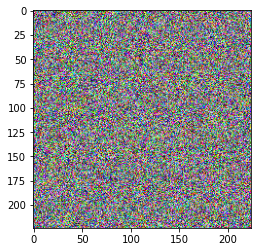

In [0]:
plt.imshow(img[0].numpy())